For the crawl, the 4pm london fix each day. 

(site)[https://www.bloomberg.com/markets/currencies/fx-fixings]

In [12]:
import sys
!{sys.executable} -m pip install selenium
!{sys.executable} -m pip install BeautifulSoup4

    100% |████████████████████████████████| 102kB 199kB/s a 0:00:01


In [195]:
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from random import randint, uniform
from time import sleep

In [3]:
url = 'https://www.bloomberg.com/markets/currencies/fx-fixings'
browser = webdriver.Chrome(executable_path='driver/chromedriver')
browser.get(url)
html_source = browser.page_source
browser.quit()

WebDriverException: Message: unknown error: cannot determine loading status
from disconnected: Unable to receive message from renderer
  (Session info: chrome=73.0.3683.20)
  (Driver info: chromedriver=73.0.3683.20 (8e2b610813e167eee3619ac4ce6e42e3ec622017),platform=Mac OS X 10.14.4 x86_64)


<!DOCTYPE html>
<html data-view-uid="0" xmlns="http://www.w3.org/1999/xhtml" xmlns:og="http://ogp.me/ns#"><head><script async="" src="https://sb.scorecardresearch.com/beacon.js"></script><script async="" src="//www.google-analytics.com/analytics.js"></script><script charset="UTF-8" src="https://cdn.taboola.com/libtrc/impl.345-189-RELEASE.js" type="text/javascript"></script><script async="" src="//widget.perfectmarket.com/bloomberg/load.js"></script><script async="" src="https://sb.scorecardresearch.com/beacon.js"></script><script src="https://www.googletagservices.com/activeview/js/current/osd.js?cb=%2Fr20100101"></script><script src="https://securepubads.g.doubleclick.net/gpt/pubads_impl_rendering_304.js"></script><script src="https://pagead2.googlesyndication.com/pagead/show_companion_ad.js"></script><script async="" src="/8FCGYgk4/init.js"></script>
<base href="https://www.bloomberg.com/"/> <meta charset="utf-8"/> <title>BFIX: Bloomberg FX Fixings - Bloomberg</title><meta content="I
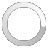

In [20]:
bs = BeautifulSoup(html_source, 'html.parser')
bs

### Extract data from a page 
**Note to self**: in the future, data structure should not be organized by day/dict but cp/dict, with each dict containing data akin to a time series.

In [199]:
def extract_currency_pairs(bs):
    cp = []
    cprows = bs.find_all('tr', {"class": "data-table-row"})
    for row in cprows: 
        name = row.find('td', {"class": "data-table-row-cell", "data-type": "name"}).text.strip()
        price_str = row.find('td', {"class": "data-table-row-cell", "data-type": "plain-text"})
        if price_str is None:
            cp.append({'name': name, 'price': None})
        else:
            cp.append({'name': name, 'price': float(price_str.text)})
            
    return cp

### Jump from one page to another
`dp = date_picker`

In [43]:
def xpath_equal_text(text):
    return "//*[text()='{}')]".format(text)
def xpath_contain_text(text):
    return "//*[contains(text(), '{}}')]".format(text)

In [6]:
dp_btn = 'ui-datepicker-trigger'
dp_id = 'ui-datepicker-div'
dp_day_selector = ['a', {"class": "ui-state-default"}]
dy_prev_month_selector = ['a', {"class": "ui-datepicker-prev", "data-handler": "prev"}]
dy_next_month_selector = ['a', {"class": "ui-datepicker-next", "data-handler": "next"}]

In [196]:
def rand_time_sleep(low, high, maxval):
    """This function simulates normal browsing behavior by introducing random delays between page jumps"""
    i = uniform(0, 1)
    if i < 0.85:
        sleep_time = randint(low, high)
    else: 
        sleep_time = randint(high, maxval)
    print("sleep for {} secs".format(sleep_time))
    sleep(sleep_time)

In [148]:
def get_current_date(driver):
    """This function gets the page's current date, as displayed in the date text box.
    Expected behavior:
        This function is prone to StaleElementReferenceException. Should this exception be caught, 
        a false datetime object would be returned (date 01/01/1970).
        As such, this function is expected to be placed in a `while` loop in the calling function. 
        This function should be called repeatedly until current date is returned. 
    """
    try:
        date_str = driver.find_element_by_id('datepicker').get_attribute('value')
    except Exception:
        print ('StaleElementReferenceException while trying to get current date')
        return datetime(1970, 1, 1)
    mo = int(date_str[:2])
    day = int(date_str[3:5])
    year = int(date_str[-4:])
    date = datetime(year, mo, day)
    return date

In [132]:
def is_date_equal(date1, date2): 
    """This function tests if two datetime objects are equal in date (time not tested)"""
    return (date1.year == date2.year and date1.month == date2.month and date1.day == date2.day)

In [176]:
def update_page_date(driver, target_date):
    dp = driver.find_element_by_id('datepicker')
    for _ in range(10):
        dp.send_keys(Keys.BACKSPACE)
    dp.send_keys(target_date.strftime('%m/%d/%Y'))
    for _ in range(2):
        dp.send_keys(Keys.ENTER)
    pass

In [136]:
print(datetime.strptime('JAN', '%b'))

1900-01-01 00:00:00


In [130]:
def check_cp_timezone(driver, location):
    """This function ensures the page's timezone is consistent with the `location` argument"""
    driver.implicitly_wait(2)
    dropdown = driver.find_element_by_class_name('data-table__time').find_element_by_tag_name('select')
    dropdown.click()
    drop_options = driver.find_elements_by_tag_name('option')
    for option in drop_options:
        if location in option.text:
            option.click()
            sleep(2)
            return

In [204]:
def bloomberg_cp_scraper():
    cp_hist = {}
    url = 'https://www.bloomberg.com/markets/currencies/fx-fixings'
    driver = webdriver.Chrome(executable_path='driver/chromedriver')
    driver.get(url)
    check_cp_timezone(driver, "London")
    try:
        today = datetime.today()
        for decr_day in range(242):
            d = today - timedelta(days=decr_day)
            update_page_date(driver, d)
            rand_time_sleep(1, 3, 20)
            html_source = driver.page_source
            bs = BeautifulSoup(html_source, 'html.parser')
            cp = extract_currency_pairs(bs)
            cp_hist[d] = cp
    except:
        return cp_hist
        
    driver.quit()
    return cp_hist

In [205]:
cp_hist = bloomberg_cp_scraper()

sleep for 3 secs
sleep for 3 secs
sleep for 1 secs
sleep for 1 secs
sleep for 17 secs
sleep for 3 secs
sleep for 3 secs
sleep for 3 secs
sleep for 2 secs
sleep for 3 secs
sleep for 2 secs
sleep for 1 secs
sleep for 2 secs
sleep for 3 secs
sleep for 16 secs
sleep for 2 secs
sleep for 2 secs
sleep for 19 secs
sleep for 3 secs
sleep for 19 secs
sleep for 2 secs
sleep for 3 secs
sleep for 1 secs
sleep for 1 secs
sleep for 1 secs
sleep for 14 secs
sleep for 2 secs
sleep for 1 secs
sleep for 1 secs
sleep for 3 secs
sleep for 1 secs
sleep for 2 secs
sleep for 3 secs
sleep for 3 secs
sleep for 3 secs
sleep for 2 secs
sleep for 1 secs
sleep for 2 secs
sleep for 3 secs
sleep for 7 secs
sleep for 19 secs
sleep for 2 secs
sleep for 1 secs
sleep for 2 secs
sleep for 1 secs
sleep for 1 secs
sleep for 2 secs
sleep for 7 secs
sleep for 3 secs
sleep for 3 secs
sleep for 3 secs
sleep for 2 secs
sleep for 9 secs
sleep for 1 secs
sleep for 3 secs
sleep for 1 secs
sleep for 3 secs
sleep for 10 secs
sleep f

In [206]:
print(cp_hist)

{datetime.datetime(2019, 2, 12, 22, 35, 32, 863792): [{'name': 'MXN-CAD', 'price': 0.0688}, {'name': 'GBP-CAD', 'price': 1.7077}, {'name': 'USD-DKK', 'price': 6.60495}, {'name': 'XAU-USD', 'price': 1309.7}, {'name': 'USD-MXN', 'price': 19.2786}, {'name': 'THB-CAD', 'price': 4.2366}, {'name': 'BRL-CAD', 'price': 0.3555}, {'name': 'ZAR-CAD', 'price': 0.0962}, {'name': 'USD-JPY', 'price': 110.515}, {'name': 'GBP-JPY', 'price': 142.371}, {'name': 'USD-CNH', 'price': 6.777}, {'name': 'EUR-PHP', 'price': 58.8885}, {'name': 'USD-ILS', 'price': 3.6373}, {'name': 'EUR-KRW', 'price': 1269.5}, {'name': 'EUR-NZD', 'price': 1.6777}, {'name': 'PEN-CAD', 'price': 0.3977}, {'name': 'USD-SGD', 'price': 1.3575}, {'name': 'EUR-INR', 'price': 79.9765}, {'name': 'EUR-ZAR', 'price': 15.5766}, {'name': 'AUD-JPY', 'price': 78.35}, {'name': 'EUR-CZK', 'price': 25.878}, {'name': 'EUR-SEK', 'price': 10.4934}, {'name': 'USD-ZAR', 'price': 13.7864}, {'name': 'EUR-PLN', 'price': 4.3304}, {'name': 'USD-THB', 'price'